# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

# Load one sample

In [8]:
%run ../common/__init__.py

In [2]:
DATASET_DIR = os.environ.get('DATASET_DIR_CHEXPERT')
image_fpath = os.path.join(DATASET_DIR, 'train/patient00001/study1/view1_frontal.jpg')

In [36]:
image = Image.open(image_fpath).convert('RGB')
image.size

(389, 320)

In [37]:
image = np.array(image)
image.shape

(320, 389, 3)

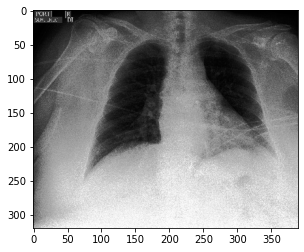

In [46]:
plt.imshow(image)

# Calculate mean and std

In [66]:
%run ../../utils/images.py

In [89]:
fpath = os.path.join(DATASET_DIR, 'train.csv')
d = pd.read_csv(fpath)
d.replace(r'CheXpert-v1.0-small/', '', regex=True, inplace=True)
d.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [90]:
train_images_all = list(d['Path'])
len(train_images_all)

223414

In [91]:
train_images_frontal = list(d[d['Frontal/Lateral'] == 'Frontal']['Path'])
len(train_images_frontal)

191027

In [92]:
mean, std = compute_mean_std(ImageFolderIterator(DATASET_DIR, train_images_all), show=True)
mean, std

  0%|          | 0/223414 [00:00<?, ?it/s]

(tensor([0.5031, 0.5031, 0.5031]), tensor([0.2913, 0.2913, 0.2913]))

In [93]:
stats_frontal = compute_mean_std(ImageFolderIterator(DATASET_DIR, train_images_frontal),
                                 show=True)
stats_frontal

  0%|          | 0/191027 [00:00<?, ?it/s]

(tensor([0.5065, 0.5065, 0.5065]), tensor([0.2895, 0.2895, 0.2895]))

# Load `ChexpertDataset` class

In [101]:
%run ../chexpert.py
%run ../../utils/common.py

In [106]:
dataset = ChexpertDataset(dataset_type='val', frontal_only=False)
len(dataset)

234

In [109]:
item = dataset[1]
item.image.size()

torch.Size([3, 512, 512])

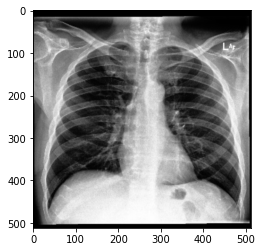

In [110]:
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))

# Exploratory analysis

In [3]:
%run ../chexpert.py

In [4]:
train_dataset = ChexpertDataset(dataset_type='train', frontal_only=False)
val_dataset = ChexpertDataset(dataset_type='val', frontal_only=False)
len(train_dataset), len(val_dataset)

(223414, 234)

## Frontal vs lateral

Amount of images

In [16]:
def print_frontal_vs_lateral(dataset):
    counter = Counter(dataset.label_index['Frontal/Lateral'])
    print(dataset.dataset_type)
    for key in counter.keys():
        amount = counter[key]
        perc = amount / len(dataset) * 100
        print(f'\t{key}: {amount:,} ({perc:.1f}%)')

In [17]:
print_frontal_vs_lateral(train_dataset)
print_frontal_vs_lateral(val_dataset)

train
	Frontal: 191,027 (85.5%)
	Lateral: 32,387 (14.5%)
val
	Frontal: 202 (86.3%)
	Lateral: 32 (13.7%)


## Diseases distribution

In [24]:
def amounts_by_disease(dataset):
    amounts = dataset.label_index[CHEXPERT_DISEASES].sum(axis=0).sort_values()

    print(dataset.dataset_type)
    for disease in amounts.keys():
        amount = int(amounts[disease])
        perc = amount / len(dataset) * 100
        print(f'\t{disease:<28}: {amount:<7,} ({perc:.1f}%)')

In [25]:
amounts_by_disease(train_dataset)
amounts_by_disease(val_dataset)

train
	Pleural Other               : 6,176   (2.8%)
	Fracture                    : 9,682   (4.3%)
	Lung Lesion                 : 10,674  (4.8%)
	No Finding                  : 22,381  (10.0%)
	Pneumothorax                : 22,593  (10.1%)
	Enlarged Cardiomediastinum  : 23,201  (10.4%)
	Pneumonia                   : 24,809  (11.1%)
	Cardiomegaly                : 35,087  (15.7%)
	Consolidation               : 42,525  (19.0%)
	Edema                       : 65,230  (29.2%)
	Atelectasis                 : 67,115  (30.0%)
	Pleural Effusion            : 97,815  (43.8%)
	Lung Opacity                : 111,179 (49.8%)
	Support Devices             : 117,080 (52.4%)
val
	Fracture                    : 0       (0.0%)
	Lung Lesion                 : 1       (0.4%)
	Pleural Other               : 1       (0.4%)
	Pneumonia                   : 8       (3.4%)
	Pneumothorax                : 8       (3.4%)
	Consolidation               : 33      (14.1%)
	No Finding                  : 38      (16.2%)
	Edema     

In [32]:
def plot_amounts_by_disease(dataset):
    amounts = dataset.label_index[CHEXPERT_DISEASES].sum(axis=0).sort_values()
    
    plt.title(dataset.dataset_type)
    plt.bar(amounts.keys(), amounts)
    plt.xticks(rotation=90)
    plt.ylabel('Amount')

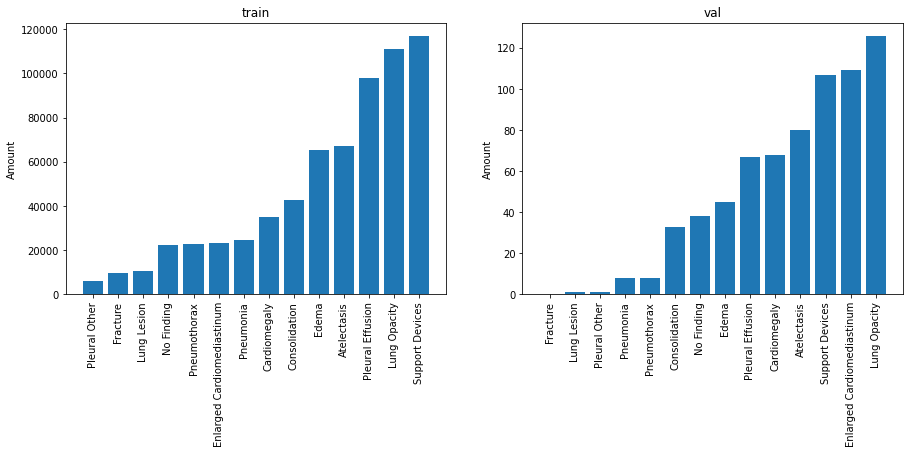

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_amounts_by_disease(train_dataset)

plt.subplot(1, 2, 2)
plot_amounts_by_disease(val_dataset)